# GETAROUND Project: deployment machine learning module

The following analysis is being done as a mandatory project for certification bloc 5 (Machine Learning Engineer at Jedha).

In the scope of the project: 

Part 1 : Implementation of a minimum delay between two rentals 

1. Understanding the business context of the given data through EDA:
    - Analysis of delays in car returns and conflicts (getaround_delay_analysis dataset)
    - Simulating minimum thresholds of delay for better decision-making
    - Conclusions
2. Creating a visual dashboard with Streamlit (hosted on Hugging Face)

Part 2 : Machine Learning pricing optimization model - training and deployment

3. Building a ML model for pricing optimization on the basis of the given data
    - Analysis of the pricing dataset and data pre-processing
    - Training 3 different ML models for pricing optimization
    - Best model selection based on evaluation metrics
4. Builiding an API to create a /predict endpoint for pricing predictions 
based on the previously created ML model
5. Preparing the API Documentation to provide clear usage instructions at /docs.
6. Deployment: hosting everything online

# Part 1 : Implementation of a minimum delay between two rentals 

In [1]:
# Setting up the environment

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
df = pd.read_excel("../data/get_around_delay_analysis.xlsx")

In [3]:
# First look at the data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


,rental_id,car_id,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,16346.000000,1841.000000,1841.000000
mean,549712.880338,350030.603426,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,67.000000,560823.000000,540.000000
max,576401.000000,417675.000000,71084.000000,575053.000000,720.000000


In [4]:
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [5]:
# Filtering to keep only 'ended' rentals
df = df[df["state"] == "ended"]

In [6]:
# Checking for missing values
df.isnull().sum()

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   1700
previous_ended_rental_id                      16433
time_delta_with_previous_rental_in_minutes    16433
dtype: int64

In [7]:
# For further analysis, we will keep non-null rows 'delay_at_checkout_in_minutes' (core metric)
df = df[df["delay_at_checkout_in_minutes"].notnull()]

In [8]:
# Converting Delay Columns to Numeric
df["delay_at_checkout_in_minutes"] = pd.to_numeric(df["delay_at_checkout_in_minutes"], errors='coerce')
df["time_delta_with_previous_rental_in_minutes"] = pd.to_numeric(df["time_delta_with_previous_rental_in_minutes"], errors="coerce")

In [9]:
# Creating a Conflict Flag (this will help later when simulating delay thresholds)
df["conflict"] = df["delay_at_checkout_in_minutes"] > df["time_delta_with_previous_rental_in_minutes"]

In [10]:
# Saving cleaned dataframe for further analysis
df.to_csv("../data/cleaned_getaround_data.csv", index=False)


EDA Step 1: Visualize Delay Distribution

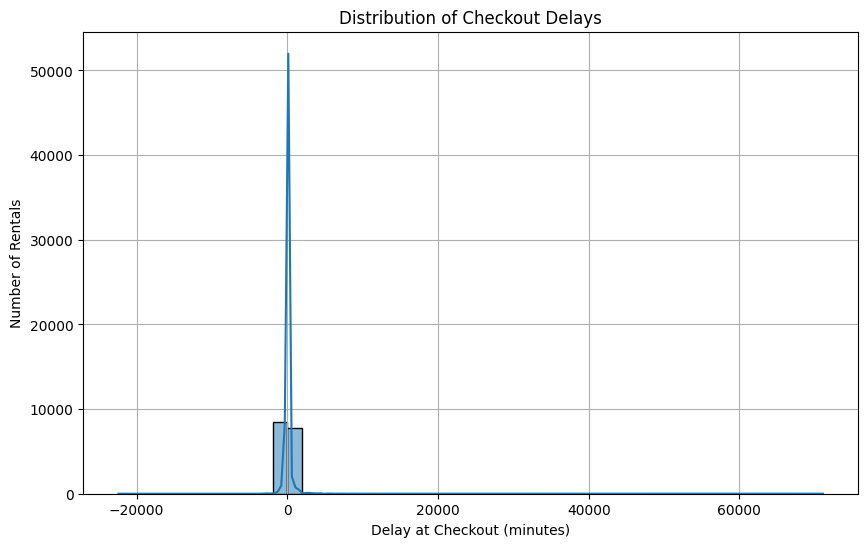

In [11]:
# Plotting the distribution of checkout delays

plt.figure(figsize=(10, 6))
sns.histplot(df["delay_at_checkout_in_minutes"], bins=50, kde=True)
plt.title("Distribution of Checkout Delays")
plt.xlabel("Delay at Checkout (minutes)")
plt.ylabel("Number of Rentals")
plt.grid(True)
plt.show()


The above histplot shows a certain number of rentals with a negative delay at check out which we can interpret as check out in advance, meaning the car was returned ahead of schedule. For the analysis Getaround is asking for, we shall narrow it down as we are interested in real delays and not in overall behaviour pattern of customers.

In [12]:
# Narrowing down to delayed rentals only for further analysis

df_delays = df[df["delay_at_checkout_in_minutes"] > 0]

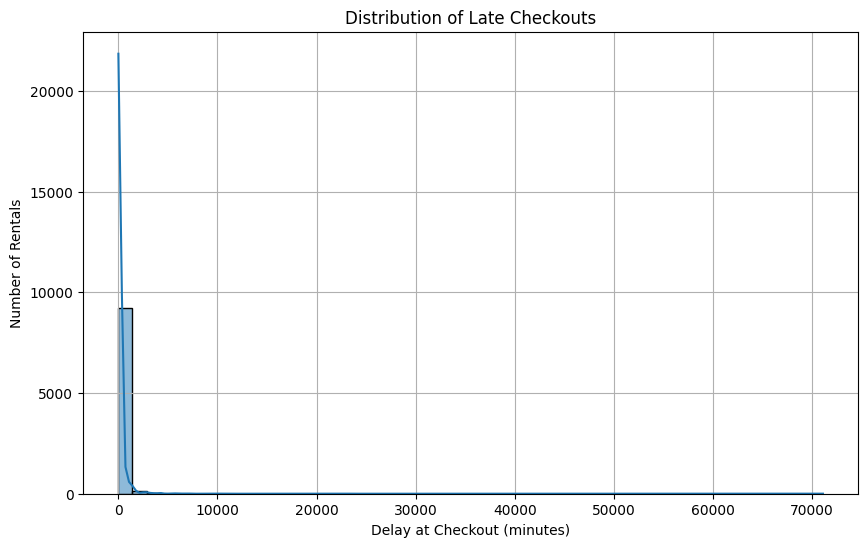

In [13]:
# Replotting the histogram with only real delays
plt.figure(figsize=(10, 6))
sns.histplot(df_delays["delay_at_checkout_in_minutes"], bins=50, kde=True)
plt.title("Distribution of Late Checkouts")
plt.xlabel("Delay at Checkout (minutes)")
plt.ylabel("Number of Rentals")
plt.grid(True)
plt.show()

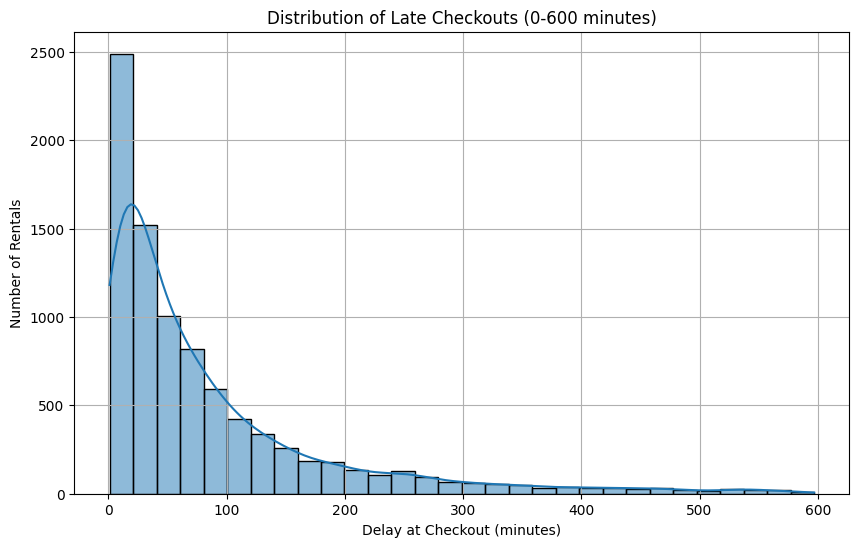

In [14]:
# Zooming in on delays between 0 and 600 minutes
plt.figure(figsize=(10, 6))
sns.histplot(df_delays[df_delays["delay_at_checkout_in_minutes"] <= 600]["delay_at_checkout_in_minutes"], bins=30, kde=True)
plt.title("Distribution of Late Checkouts (0-600 minutes)")
plt.xlabel("Delay at Checkout (minutes)")
plt.ylabel("Number of Rentals")
plt.grid(True)
plt.show()


In [15]:
# Let's see how many rentals fall into different delay thresholds for context
thresholds = [15, 30, 60, 90, 120, 360, 600]
for t in thresholds:
    late_rentals = df[df["delay_at_checkout_in_minutes"] > t]
    print(f"Delay > {t} min → {len(late_rentals)} rentals")


Delay > 15 min → 7416 rentals
Delay > 30 min → 6078 rentals
Delay > 60 min → 4386 rentals
Delay > 90 min → 3257 rentals
Delay > 120 min → 2553 rentals
Delay > 360 min → 885 rentals
Delay > 600 min → 574 rentals


EDA step 2: Simulate Delay Thresholds Impact

In [21]:
# We will simulate the impact of different delay thresholds on rental conflicts.
# The below simulation is only counting the late rentals that would block the next rental 
# under a given threshold (the delay is longer than the time gap to the next rental)

from IPython.display import display, HTML
import pandas as pd

thresholds = [15, 30, 60, 90, 120, 360, 600]
results = []

for t in thresholds:
    affected = df[
        (df["time_delta_with_previous_rental_in_minutes"].notnull()) &
        (df["delay_at_checkout_in_minutes"] > df["time_delta_with_previous_rental_in_minutes"]) &
        (df["time_delta_with_previous_rental_in_minutes"] < t)
    ]
    results.append({
        'Threshold (min)': t,
        'Rentals Affected': len(affected)
    })
    print(f"Threshold {t} min → {len(affected)} rentals affected")

# Create a DataFrame for better visibility
results_df = pd.DataFrame(results)
display(results_df)


Threshold 15 min → 136 rentals affected
Threshold 30 min → 136 rentals affected
Threshold 60 min → 176 rentals affected
Threshold 90 min → 213 rentals affected
Threshold 120 min → 224 rentals affected
Threshold 360 min → 255 rentals affected
Threshold 600 min → 261 rentals affected


,Threshold (min),Rentals Affected
0,15,136
1,30,136
2,60,176
3,90,213
4,120,224
5,360,255
6,600,261


What is a conflict situation in this situation?
A conflict occurs when a rental is returned late, and the next rental was scheduled too soon after the previous one. The delay exceeds the time gap between rentals. In other words: the car wasn’t returned in time for the next driver.

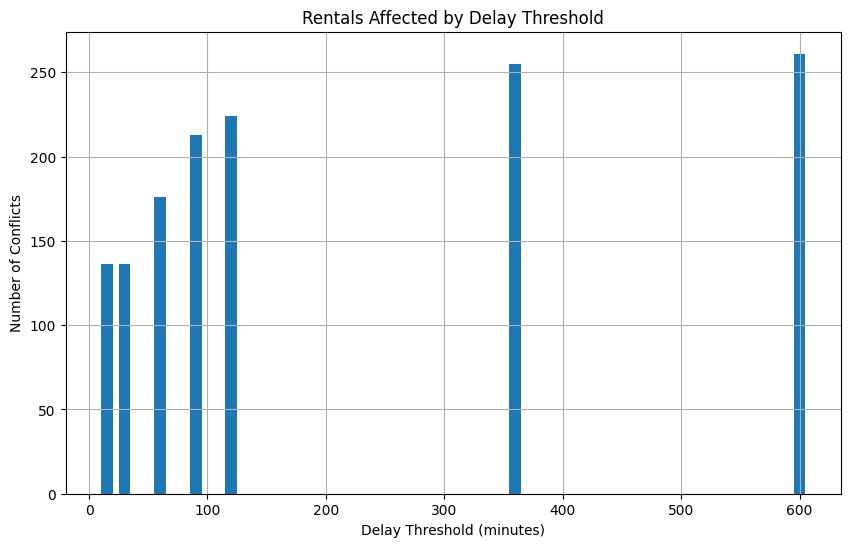

In [17]:
# Visualize the Impact of Delay Thresholds 

conflict_counts = []

for t in thresholds:
    affected = df[
        (df["time_delta_with_previous_rental_in_minutes"].notnull()) &
        (df["delay_at_checkout_in_minutes"] > df["time_delta_with_previous_rental_in_minutes"]) &
        (df["time_delta_with_previous_rental_in_minutes"] < t)
    ]
    conflict_counts.append(len(affected))

plt.figure(figsize=(10, 6))
plt.bar(thresholds, conflict_counts, width=10)
plt.title("Rentals Affected by Delay Threshold")
plt.xlabel("Delay Threshold (minutes)")
plt.ylabel("Number of Conflicts")
plt.grid(True)
plt.show()


EDA Step 3: Compare Connect vs. Non-Connect Cars

Connect cars:
count    3402.000000
mean      -43.627278
std       228.681964
min     -4276.000000
25%       -75.750000
50%        -9.000000
75%        32.000000
max      1466.000000
Name: delay_at_checkout_in_minutes, dtype: float64

Non-Connect cars:
count    12943.000000
mean        88.215174
std       1108.296230
min     -22433.000000
25%        -26.000000
50%         14.000000
75%         77.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64


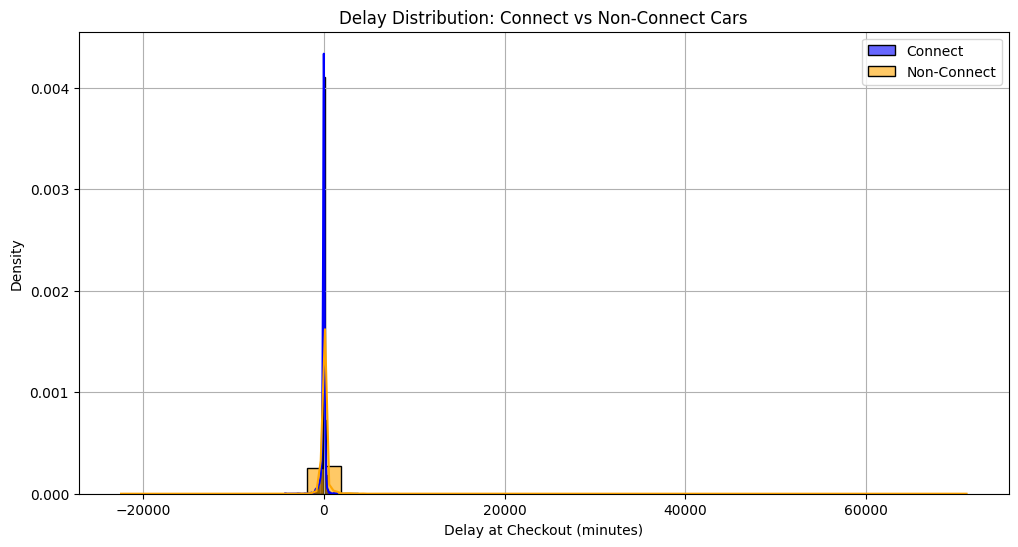

In [18]:
# Non-connect cars encompass both mobile and traditional check-in types 
# which are not differentiated in the dataset

connect_df = df[df["checkin_type"] == "connect"]
non_connect_df = df[df["checkin_type"] != "connect"]

print("Connect cars:")
print(connect_df["delay_at_checkout_in_minutes"].describe())

print("\nNon-Connect cars:")
print(non_connect_df["delay_at_checkout_in_minutes"].describe())

# Visualizing the comparison
plt.figure(figsize=(12, 6))
sns.histplot(connect_df["delay_at_checkout_in_minutes"], color='blue', label='Connect', bins=50, kde=True, stat="density", alpha=0.6)
sns.histplot(non_connect_df["delay_at_checkout_in_minutes"], color='orange', label='Non-Connect', bins=50, kde=True, stat="density", alpha=0.6)
plt.title("Delay Distribution: Connect vs Non-Connect Cars")
plt.xlabel("Delay at Checkout (minutes)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


The histplot shows that Connect cars tend to have a lower delay at checkout compared to Non-Connect cars. This suggests that the Connect system may help in reducing delays, possibly due to its automated check-in/check-out process which can streamline operations and reduce human error. Let's see how are connect cars looking with regards to all cars.

In [19]:
# Split the analysis between Connect and all cars
connect_df = df[df["checkin_type"] == "connect"]
all_df = df.copy()  # includes all checkin types


In [20]:
# Compare Delay Behavior

def delay_stats(df, label):
    total = len(df)
    late = df[df["delay_at_checkout_in_minutes"] > 0]
    percent_late = len(late) / total * 100
    print(f"{label} → Total: {total}, Late: {len(late)}, % Late: {percent_late:.2f}%")

delay_stats(connect_df, "Connect cars")
delay_stats(all_df, "All cars")


Connect cars → Total: 3402, Late: 1459, % Late: 42.89%
All cars → Total: 16345, Late: 9404, % Late: 57.53%


In [21]:
# Simulate Conflicts by Scope
def conflict_count(df, threshold):
    return len(df[
        (df["time_delta_with_previous_rental_in_minutes"].notnull()) &
        (df["delay_at_checkout_in_minutes"] > df["time_delta_with_previous_rental_in_minutes"]) &
        (df["time_delta_with_previous_rental_in_minutes"] < threshold)
    ])

threshold = 60
connect_conflicts = conflict_count(connect_df, threshold)
all_conflicts = conflict_count(all_df, threshold)

print(f"Conflicts with threshold {threshold} min:")
print(f"Connect cars → {connect_conflicts} rentals affected")
print(f"All cars     → {all_conflicts} rentals affected")


Conflicts with threshold 60 min:
Connect cars → 63 rentals affected
All cars     → 176 rentals affected


The above analysis tells us the following:

Late returns are a widespread issue, affecting over half of all rentals and nearly 43% of Connect rentals. While Connect cars perform slightly better, the difference isn’t dramatic. This means that limiting the feature to Connect cars alone might not be enough to solve the problem. This supports the idea that a broader implementation of the delay threshold could be justified, even if it comes with a revenue trade-off.

In [22]:
# Simulate Conflicts by Threshold and Scope
thresholds = [15, 30, 60, 90, 120, 360, 600]
all_conflicts = []
connect_conflicts = []

def conflict_count(df, threshold):
    return len(df[
        (df["time_delta_with_previous_rental_in_minutes"].notnull()) &
        (df["delay_at_checkout_in_minutes"] > df["time_delta_with_previous_rental_in_minutes"]) &
        (df["time_delta_with_previous_rental_in_minutes"] < threshold)
    ])

for t in thresholds:
    all_conflicts.append(conflict_count(df, t))
    connect_conflicts.append(conflict_count(df[df["checkin_type"] == "connect"], t))


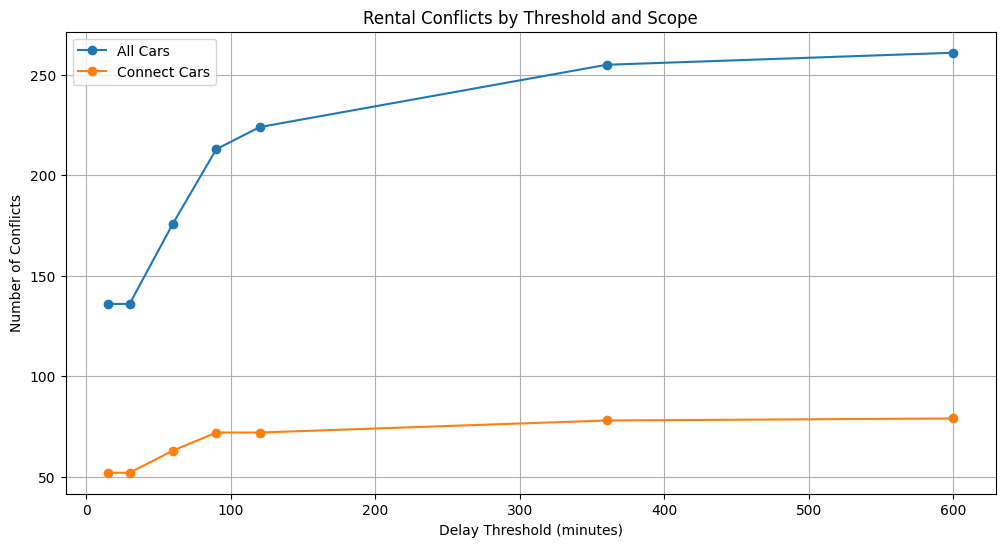

In [23]:
# Visualize the Comparison

plt.figure(figsize=(12, 6))
plt.plot(thresholds, all_conflicts, label="All Cars", marker='o')
plt.plot(thresholds, connect_conflicts, label="Connect Cars", marker='o')
plt.title("Rental Conflicts by Threshold and Scope")
plt.xlabel("Delay Threshold (minutes)")
plt.ylabel("Number of Conflicts")
plt.legend()
plt.grid(True)
plt.show()


Interpretation

All cars consistently show more conflicts, which confirms that late returns are a broader issue. Connect Cars show fewer conflicts, but still a relatively significant number. The gap between the two curves helps justify whether the feature should be applied globally or selectively.

Conclusion

In order to mitigate the frictions between late returns that affect the next rentals, a solution to implement a minimum delay between two rentals seems to be a good tool to prevent a number of conflicts: a car won’t be displayed in the search results if the requested checkin or checkout times are too close from an already booked rental.

It solves potentially the late checkout issue but might hurt Getaround/owners revenues: so it is important to find the right trade off in order to minimize (=> not eliminate) the conflicts but allow the owner enought revenues opportunities. 

The decision belongs to the Product Manager, however setting a minimum delay at 90 minutes seems a reasonable trade-off: it saves potentially 213 rentals (based on the dataset given for this analysis), but it's not excessively long for the owners. The Product Manager may further simulate different threshholds using the Streamlit Dashboard to take the best decision.

As suggested above, it seems reasonable as well to implement this feature to all cars given that the conflict frictions appear to be a widespread problem.